In [1]:
'''
    Opening notebook remotely on MacOS --> jupyter-notebook --no-browser --port=9090
'''

'\n    Opening notebook remotely on MacOS --> jupyter-notebook --no-browser --port=9090\n'

In [2]:
!echo $CUDA_VISIBLE_DEVICES

1


In [3]:
from sklearn.metrics import classification_report
from keras.models import load_model
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import seaborn as sns

2023-11-27 19:16:11.127224: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
shared_dir = "/s/bach/a/class/cs435/cs435a/"
image_dir = "CS435_Plant_Data_v2_augment-v2/2023-11-15-231056/"

orig_test = "splits/original/orig_test.csv"
aug_test = "splits/augmented/aug_test.csv"

orig_test_path = shared_dir+image_dir+orig_test
aug_test_path = shared_dir+image_dir+aug_test

In [5]:
orig_model_name = shared_dir + "models/trained_original.h5"
aug_model_name = shared_dir + "models/trained_augmented.h5"
orig_model = load_model(orig_model_name)
aug_model = load_model(aug_model_name)

2023-11-27 19:16:15.092144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 19:16:15.616130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46693 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [6]:
orig_test_df = pd.read_csv(orig_test_path)
aug_test_df = pd.read_csv(aug_test_path)

datagen = ImageDataGenerator(rescale=1./255) #normalize from [0,255] to [0,1]
orig_test_generator = datagen.flow_from_dataframe(
    dataframe=orig_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

aug_test_generator = datagen.flow_from_dataframe(
    dataframe=aug_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

Found 7166 validated image filenames belonging to 31 classes.
Found 21580 validated image filenames belonging to 31 classes.


In [7]:
rain_test_df = aug_test_df[aug_test_df['augmentation'].str.contains('rain', case=False, na=False)]
mud_test_df = aug_test_df[aug_test_df['augmentation'].str.contains('mud', case=False, na=False)]

rain_test_generator = datagen.flow_from_dataframe(
    dataframe=rain_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

mud_test_generator = datagen.flow_from_dataframe(
    dataframe=mud_test_df, 
    x_col='path_to_shared',
    y_col='class_name',  
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical', 
    shuffle=False
)

Found 7235 validated image filenames belonging to 31 classes.
Found 7179 validated image filenames belonging to 31 classes.


In [8]:
# Basic metrics: accuracy, precision, recall, f1-score
def evaluate_model_metrics(model, test_generator, predictions):
    predicted_classes = [np.argmax(pred) for pred in predictions]

    true_classes = test_generator.classes

    class_labels = list(test_generator.class_indices.keys())

    report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    return report

In [9]:
def print_report(report):
    report_df = pd.DataFrame(report).transpose()
    
    print(f"Accuracy: {report_df.loc['accuracy', 'precision']}")
    print(f"Macro Average Precision: {report_df.loc['macro avg', 'precision']}")
    print(f"Macro Average Recall: {report_df.loc['macro avg', 'recall']}")
    print(f"Macro Average F1-Score: {report_df.loc['macro avg', 'f1-score']}")

    display(report_df)

In [10]:
print("*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***")
orig_orig_predictions = orig_model.predict(orig_test_generator)
orig_aug_predictions = orig_model.predict(aug_test_generator)
orig_rain_predictions = orig_model.predict(rain_test_generator)
orig_mud_predictions = orig_model.predict(mud_test_generator)

orig_orig_test_report = evaluate_model_metrics(orig_model, orig_test_generator, orig_orig_predictions)
orig_aug_test_report = evaluate_model_metrics(orig_model, aug_test_generator, orig_aug_predictions)
orig_rain_test_report = evaluate_model_metrics(orig_model, rain_test_generator, orig_rain_predictions)
orig_mud_test_report = evaluate_model_metrics(orig_model, mud_test_generator, orig_mud_predictions)

*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***


2023-11-27 19:16:54.451181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


 11/717 [..............................] - ETA: 13s

2023-11-27 19:16:56.370363: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


718/718 [==============================] - 11s 15ms/step


/usr/local/python-env/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python-env/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/python-env/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
print("*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_orig_test_report)

print("*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_aug_test_report)

print("*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_rain_test_report)

print("*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***")
print_report(orig_mud_test_report)

*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.9112475579123639
Macro Average Precision: 0.9273727177182105
Macro Average Recall: 0.9123216110051471
Macro Average F1-Score: 0.9111204005454999


,precision,recall,f1-score,support
Apple___Apple_scab,0.985915,0.886076,0.933333,237.000000
Apple___Black_rot,0.995868,0.902622,0.946955,267.000000
Apple___Cedar_apple_rust,0.962185,0.987069,0.974468,232.000000
Apple___healthy,0.820261,0.984314,0.894831,255.000000
Cherry_(including_sour)___Powdery_mildew,0.994681,0.973958,0.984211,192.000000
Cherry_(including_sour)___healthy,0.995215,0.967442,0.981132,215.000000
Corn_(maize)___Common_rust_,1.000000,0.990826,0.995392,218.000000
Corn_(maize)___Northern_Leaf_Blight,0.985366,0.926606,0.955083,218.000000
Corn_(maize)___healthy,0.936330,1.000000,0.967118,250.000000
Grape___Black_rot,0.943089,0.935484,0.939271,248.000000


*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.6506487488415199
Macro Average Precision: 0.8099026047122414
Macro Average Recall: 0.6505256384290945
Macro Average F1-Score: 0.6702383727449132


,precision,recall,f1-score,support
Apple___Apple_scab,0.962779,0.513228,0.669543,756.000000
Apple___Black_rot,0.794504,0.892617,0.840708,745.000000
Apple___Cedar_apple_rust,0.556008,0.827273,0.665043,660.000000
Apple___healthy,0.805380,0.675963,0.735018,753.000000
Cherry_(including_sour)___Powdery_mildew,0.963899,0.423138,0.588106,631.000000
Cherry_(including_sour)___healthy,0.991561,0.686131,0.811044,685.000000
Corn_(maize)___Common_rust_,0.754860,0.977622,0.851920,715.000000
Corn_(maize)___Northern_Leaf_Blight,0.767878,0.916084,0.835459,715.000000
Corn_(maize)___healthy,0.888889,0.677188,0.768730,697.000000
Grape___Black_rot,0.710145,0.899718,0.793769,708.000000


*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.4971665514858328
Macro Average Precision: 0.7690260421555088
Macro Average Recall: 0.49947161975776616
Macro Average F1-Score: 0.5002883304852943


,precision,recall,f1-score,support
Apple___Apple_scab,0.891566,0.276119,0.421652,268.000000
Apple___Black_rot,0.790909,0.809302,0.800000,215.000000
Apple___Cedar_apple_rust,0.320423,0.831050,0.462516,219.000000
Apple___healthy,0.685990,0.586777,0.632517,242.000000
Cherry_(including_sour)___Powdery_mildew,0.833333,0.202703,0.326087,222.000000
Cherry_(including_sour)___healthy,0.990566,0.433884,0.603448,242.000000
Corn_(maize)___Common_rust_,0.942529,0.946154,0.944338,260.000000
Corn_(maize)___Northern_Leaf_Blight,0.659509,0.881148,0.754386,244.000000
Corn_(maize)___healthy,0.818966,0.833333,0.826087,228.000000
Grape___Black_rot,0.669323,0.774194,0.717949,217.000000


*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON ORIGINAL DATA ***
Accuracy: 0.5452012815155314
Macro Average Precision: 0.7950228989485963
Macro Average Recall: 0.5402563495934466
Macro Average F1-Score: 0.5272328433901968


,precision,recall,f1-score,support
Apple___Apple_scab,0.971963,0.414343,0.581006,251.000000
Apple___Black_rot,0.666667,0.950570,0.783699,263.000000
Apple___Cedar_apple_rust,0.767045,0.645933,0.701299,209.000000
Apple___healthy,0.974790,0.453125,0.618667,256.000000
Cherry_(including_sour)___Powdery_mildew,1.000000,0.161290,0.277778,217.000000
Cherry_(including_sour)___healthy,0.987421,0.688596,0.811370,228.000000
Corn_(maize)___Common_rust_,0.527840,1.000000,0.690962,237.000000
Corn_(maize)___Northern_Leaf_Blight,0.739130,0.940711,0.827826,253.000000
Corn_(maize)___healthy,1.000000,0.146119,0.254980,219.000000
Grape___Black_rot,0.592500,0.975309,0.737170,243.000000


In [12]:
print("*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***")

*** EVALUATING MODEL TRAINED ON ORIGINAL DATA ***


In [13]:
aug_orig_predictions = aug_model.predict(orig_test_generator)

717/717 [==============================] - 10s 14ms/step


In [14]:
aug_aug_predictions = aug_model.predict(aug_test_generator)

2158/2158 [==============================] - 31s 15ms/step


In [15]:
aug_rain_predictions = aug_model.predict(rain_test_generator)

724/724 [==============================] - 11s 16ms/step


In [16]:
aug_mud_predictions = aug_model.predict(mud_test_generator)

718/718 [==============================] - 11s 15ms/step


In [17]:
aug_orig_test_report = evaluate_model_metrics(aug_model, orig_test_generator, aug_orig_predictions)
aug_aug_test_report = evaluate_model_metrics(aug_model, aug_test_generator, aug_aug_predictions)
aug_rain_test_report = evaluate_model_metrics(aug_model, rain_test_generator, aug_rain_predictions)
aug_mud_test_report = evaluate_model_metrics(aug_model, mud_test_generator, aug_mud_predictions)

In [18]:
print("*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_orig_test_report)

print("*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_aug_test_report)

print("*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_rain_test_report)

print("*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***")
print_report(aug_mud_test_report)

*** EVALUATIONS ON ORIGINAL TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9296678760814959
Macro Average Precision: 0.9392576863536143
Macro Average Recall: 0.9319632752592761
Macro Average F1-Score: 0.9305437187308214


,precision,recall,f1-score,support
Apple___Apple_scab,0.876866,0.991561,0.930693,237.000000
Apple___Black_rot,1.000000,0.925094,0.961089,267.000000
Apple___Cedar_apple_rust,1.000000,0.883621,0.938215,232.000000
Apple___healthy,0.958175,0.988235,0.972973,255.000000
Cherry_(including_sour)___Powdery_mildew,0.994792,0.994792,0.994792,192.000000
Cherry_(including_sour)___healthy,0.990741,0.995349,0.993039,215.000000
Corn_(maize)___Common_rust_,1.000000,0.963303,0.981308,218.000000
Corn_(maize)___Northern_Leaf_Blight,0.947826,1.000000,0.973214,218.000000
Corn_(maize)___healthy,0.995984,0.992000,0.993988,250.000000
Grape___Black_rot,0.995238,0.842742,0.912664,248.000000


*** EVALUATIONS ON AUGMENTED TEST DATA WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9256255792400371
Macro Average Precision: 0.9360922613577096
Macro Average Recall: 0.9265217253975924
Macro Average F1-Score: 0.9267948912159302


,precision,recall,f1-score,support
Apple___Apple_scab,0.906716,0.964286,0.934615,756.000000
Apple___Black_rot,1.000000,0.912752,0.954386,745.000000
Apple___Cedar_apple_rust,1.000000,0.850000,0.918919,660.000000
Apple___healthy,0.944872,0.978752,0.961513,753.000000
Cherry_(including_sour)___Powdery_mildew,0.975078,0.992076,0.983504,631.000000
Cherry_(including_sour)___healthy,0.988270,0.983942,0.986101,685.000000
Corn_(maize)___Common_rust_,1.000000,0.953846,0.976378,715.000000
Corn_(maize)___Northern_Leaf_Blight,0.935864,1.000000,0.966870,715.000000
Corn_(maize)___healthy,0.997114,0.991392,0.994245,697.000000
Grape___Black_rot,0.989147,0.901130,0.943089,708.000000


*** EVALUATIONS ON ONLY RAIN SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9210780926053904
Macro Average Precision: 0.9338534443457681
Macro Average Recall: 0.9227142066053101
Macro Average F1-Score: 0.9234457553981547


,precision,recall,f1-score,support
Apple___Apple_scab,0.918819,0.929104,0.923933,268.000000
Apple___Black_rot,1.000000,0.902326,0.948655,215.000000
Apple___Cedar_apple_rust,1.000000,0.835616,0.910448,219.000000
Apple___healthy,0.962963,0.966942,0.964948,242.000000
Cherry_(including_sour)___Powdery_mildew,0.956332,0.986486,0.971175,222.000000
Cherry_(including_sour)___healthy,0.995781,0.975207,0.985386,242.000000
Corn_(maize)___Common_rust_,1.000000,0.961538,0.980392,260.000000
Corn_(maize)___Northern_Leaf_Blight,0.931298,1.000000,0.964427,244.000000
Corn_(maize)___healthy,1.000000,0.995614,0.997802,228.000000
Grape___Black_rot,1.000000,0.921659,0.959233,217.000000


*** EVALUATIONS ON ONLY MUD SPATTER AUGMENTED IMAGES WITH MODEL TRAINED ON AUGMENTED DATA ***
Accuracy: 0.9261735617774063
Macro Average Precision: 0.9374481071201958
Macro Average Recall: 0.9255351196814167
Macro Average F1-Score: 0.9268377999826977


,precision,recall,f1-score,support
Apple___Apple_scab,0.924528,0.976096,0.949612,251.000000
Apple___Black_rot,1.000000,0.908745,0.952191,263.000000
Apple___Cedar_apple_rust,1.000000,0.827751,0.905759,209.000000
Apple___healthy,0.916058,0.980469,0.947170,256.000000
Cherry_(including_sour)___Powdery_mildew,0.977376,0.995392,0.986301,217.000000
Cherry_(including_sour)___healthy,0.978166,0.982456,0.980306,228.000000
Corn_(maize)___Common_rust_,1.000000,0.936709,0.967320,237.000000
Corn_(maize)___Northern_Leaf_Blight,0.930147,1.000000,0.963810,253.000000
Corn_(maize)___healthy,0.995392,0.986301,0.990826,219.000000
Grape___Black_rot,0.974468,0.942387,0.958159,243.000000


In [19]:
# More advanced metrics: Confusion Matrix
def create_model_confusion_matrix(model, test_generator, model_name, test_df, predictions):
#     predicted_classes = np.argmax(predictions, axis=1)

#     label_map = {label: index for index, label in enumerate(test_generator.class_indices)}
#     true_classes = test_df['class_name'].map(label_map).values

#     conf_matrix = confusion_matrix(true_classes, predicted_classes)

#     plt.figure(figsize=(20, 20))
#     sns.heatmap(conf_matrix, annot=True, fmt='g')
#     plt.xlabel('Predicted labels')
#     plt.ylabel('True labels')
#     plt.title('Confusion Matrix')

#     # plt.savefig(model_name+'_aug_confusion_matrix.png')
#     plt.show()

    predicted_classes = np.argmax(predictions, axis=1)

    label_map = {v: k for k, v in test_generator.class_indices.items()}
    predicted_class_names = [label_map[k] for k in predicted_classes]
    true_class_names = test_df['class_name'].values
    conf_matrix = confusion_matrix(true_class_names, predicted_class_names, labels=list(label_map.values()))
    conf_matrix_df = pd.DataFrame(conf_matrix, index=label_map.values(), columns=label_map.values())

    # Plotting
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix_df, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(model_name.replace('_',' '), fontsize=20)
    plt.savefig('figures/'+model_name+'.png',bbox_inches='tight')
    plt.show()


# CM for Original Model

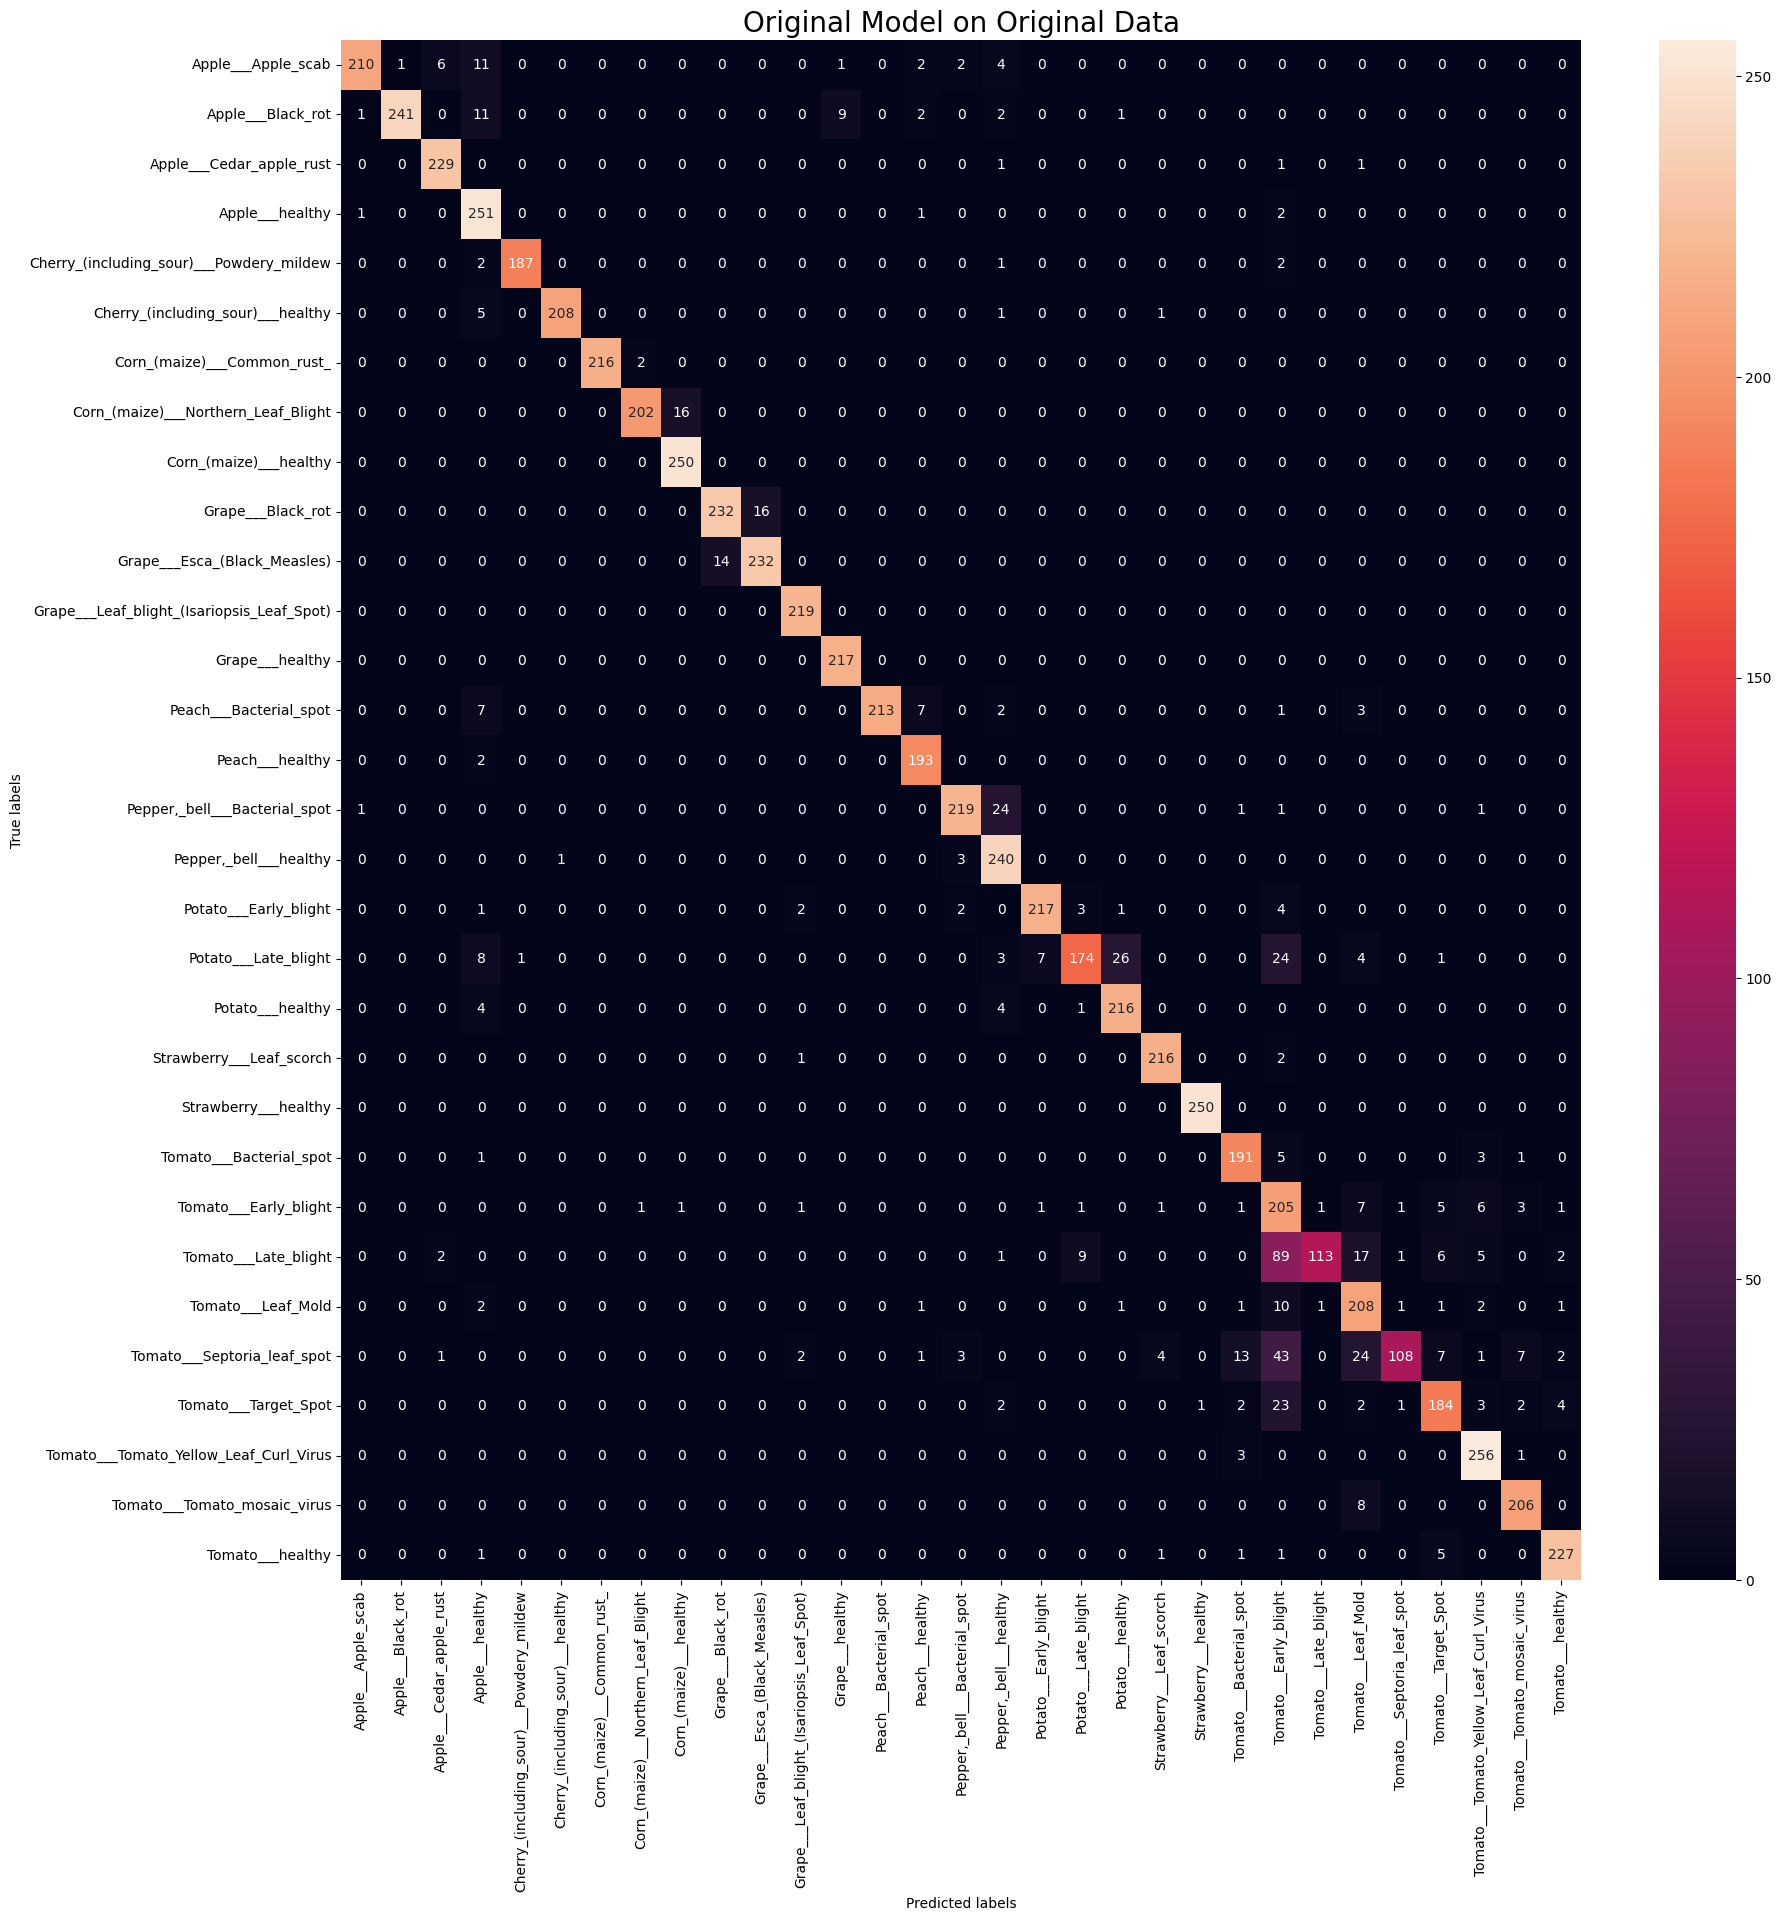

In [20]:
create_model_confusion_matrix(orig_model, orig_test_generator, 
                              "Original_Model_on_Original_Data", orig_test_df, 
                              orig_orig_predictions)

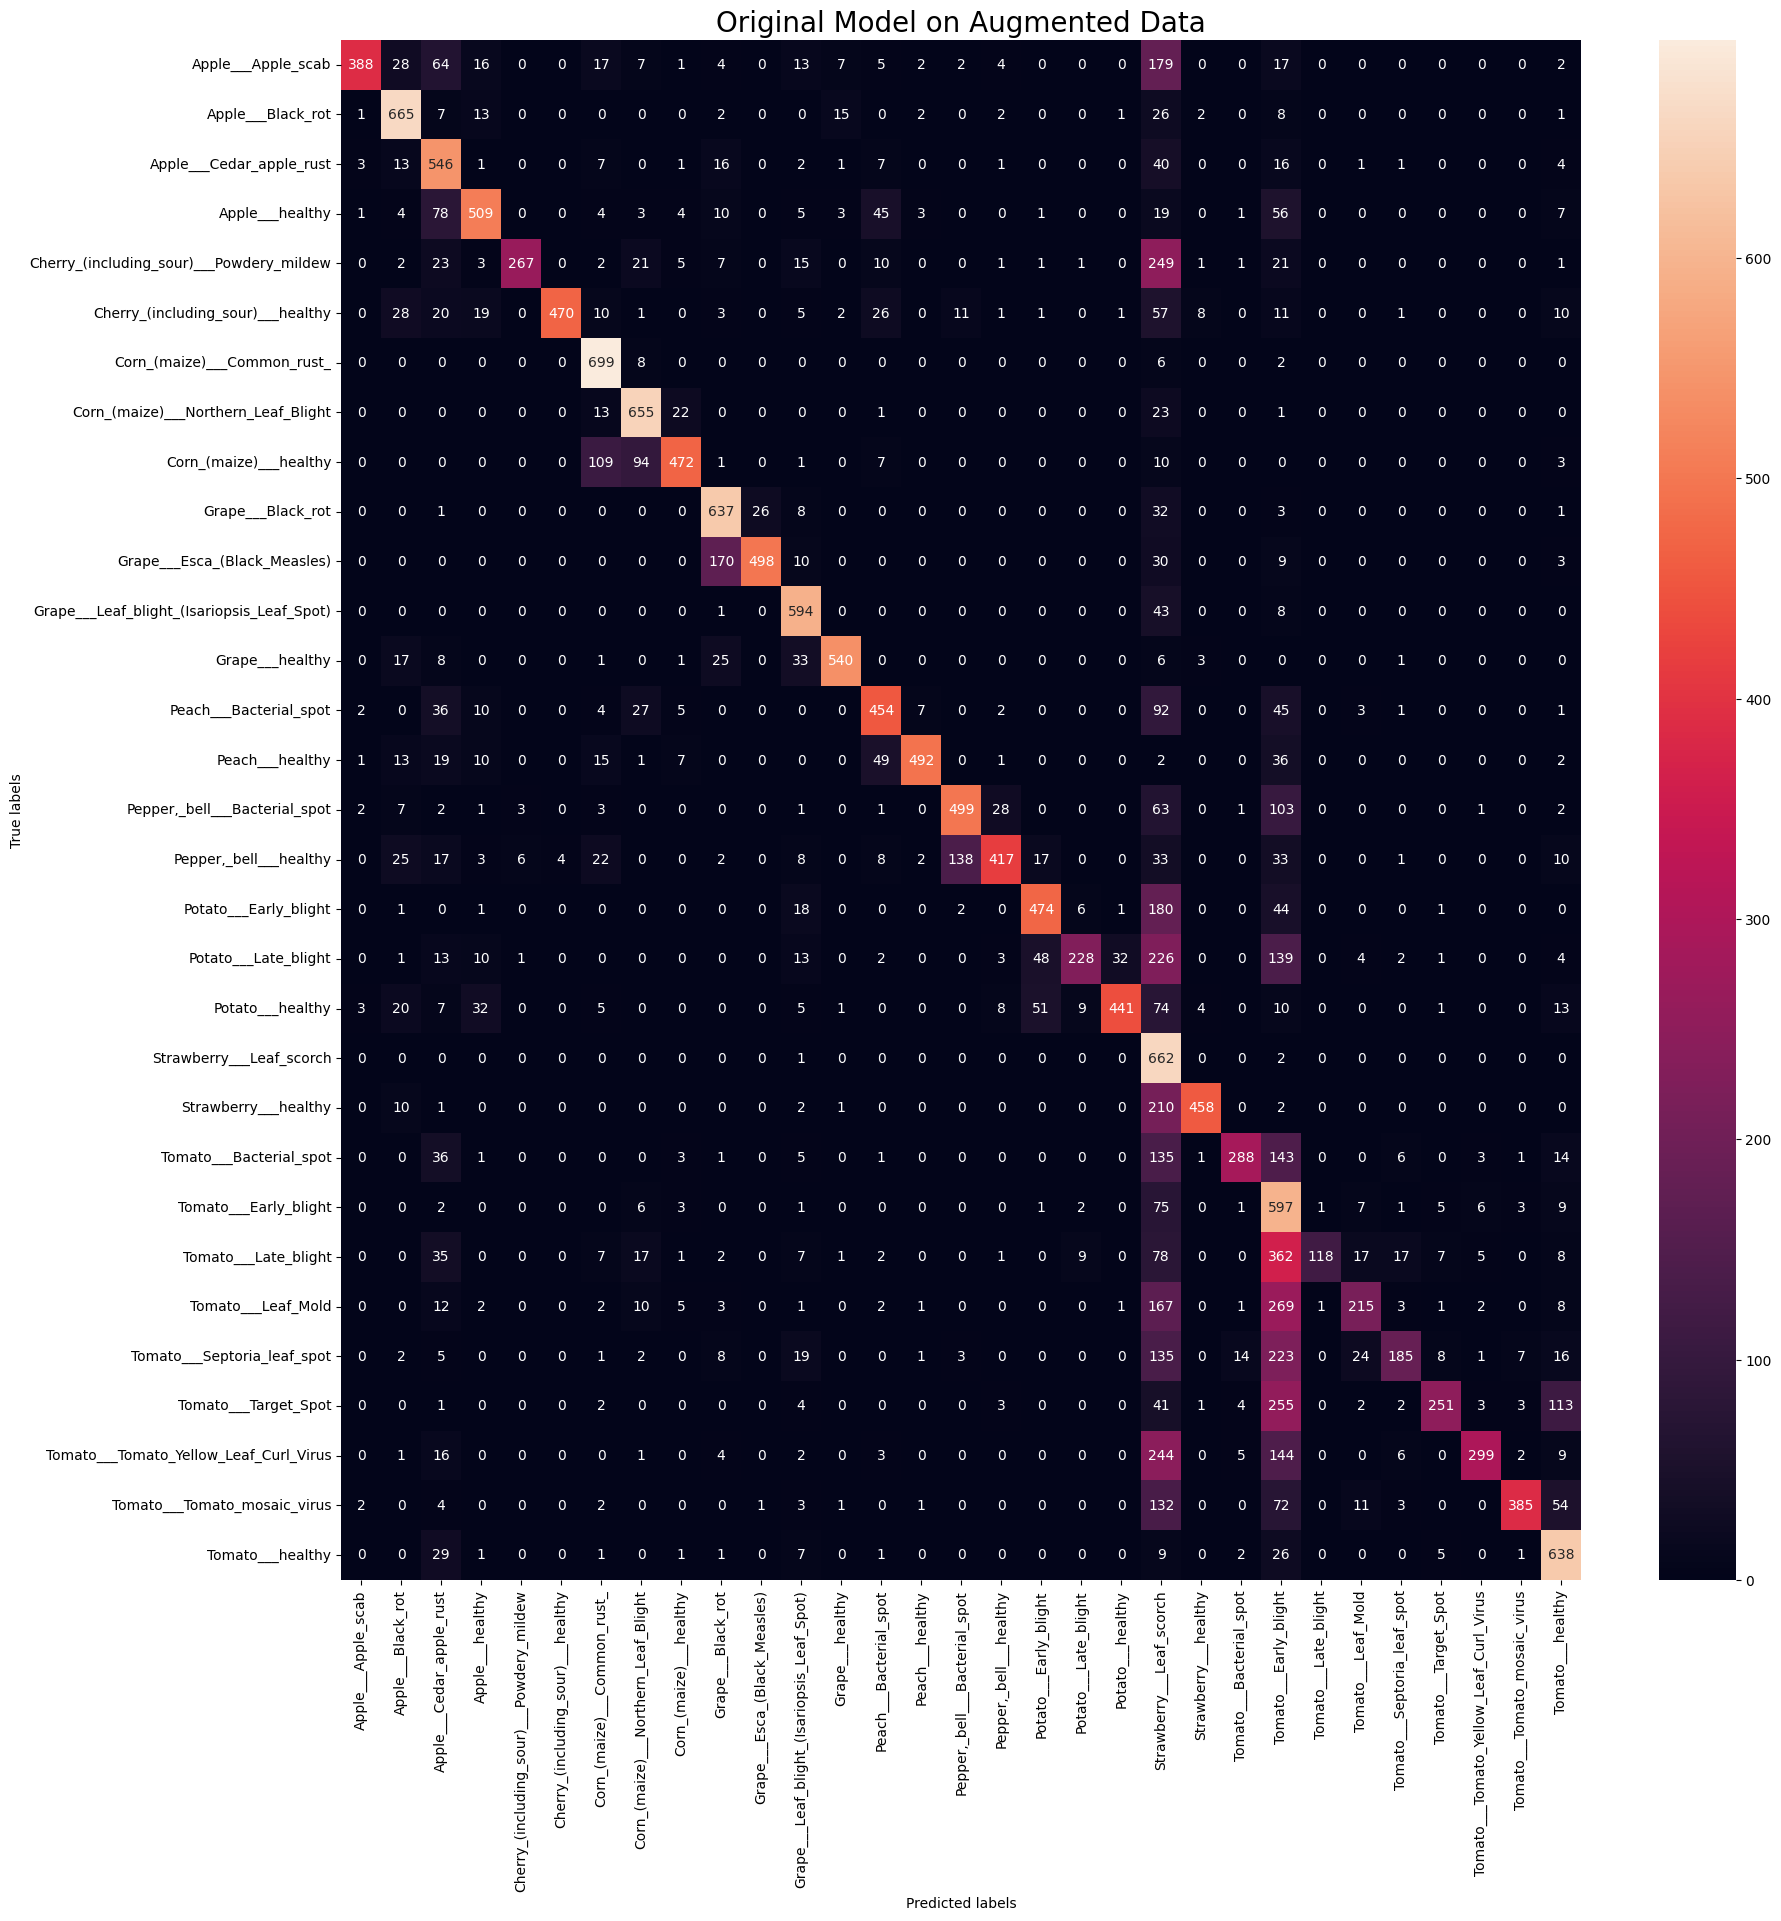

In [21]:
create_model_confusion_matrix(orig_model, aug_test_generator, 
                              "Original_Model_on_Augmented_Data", aug_test_df, 
                              orig_aug_predictions)

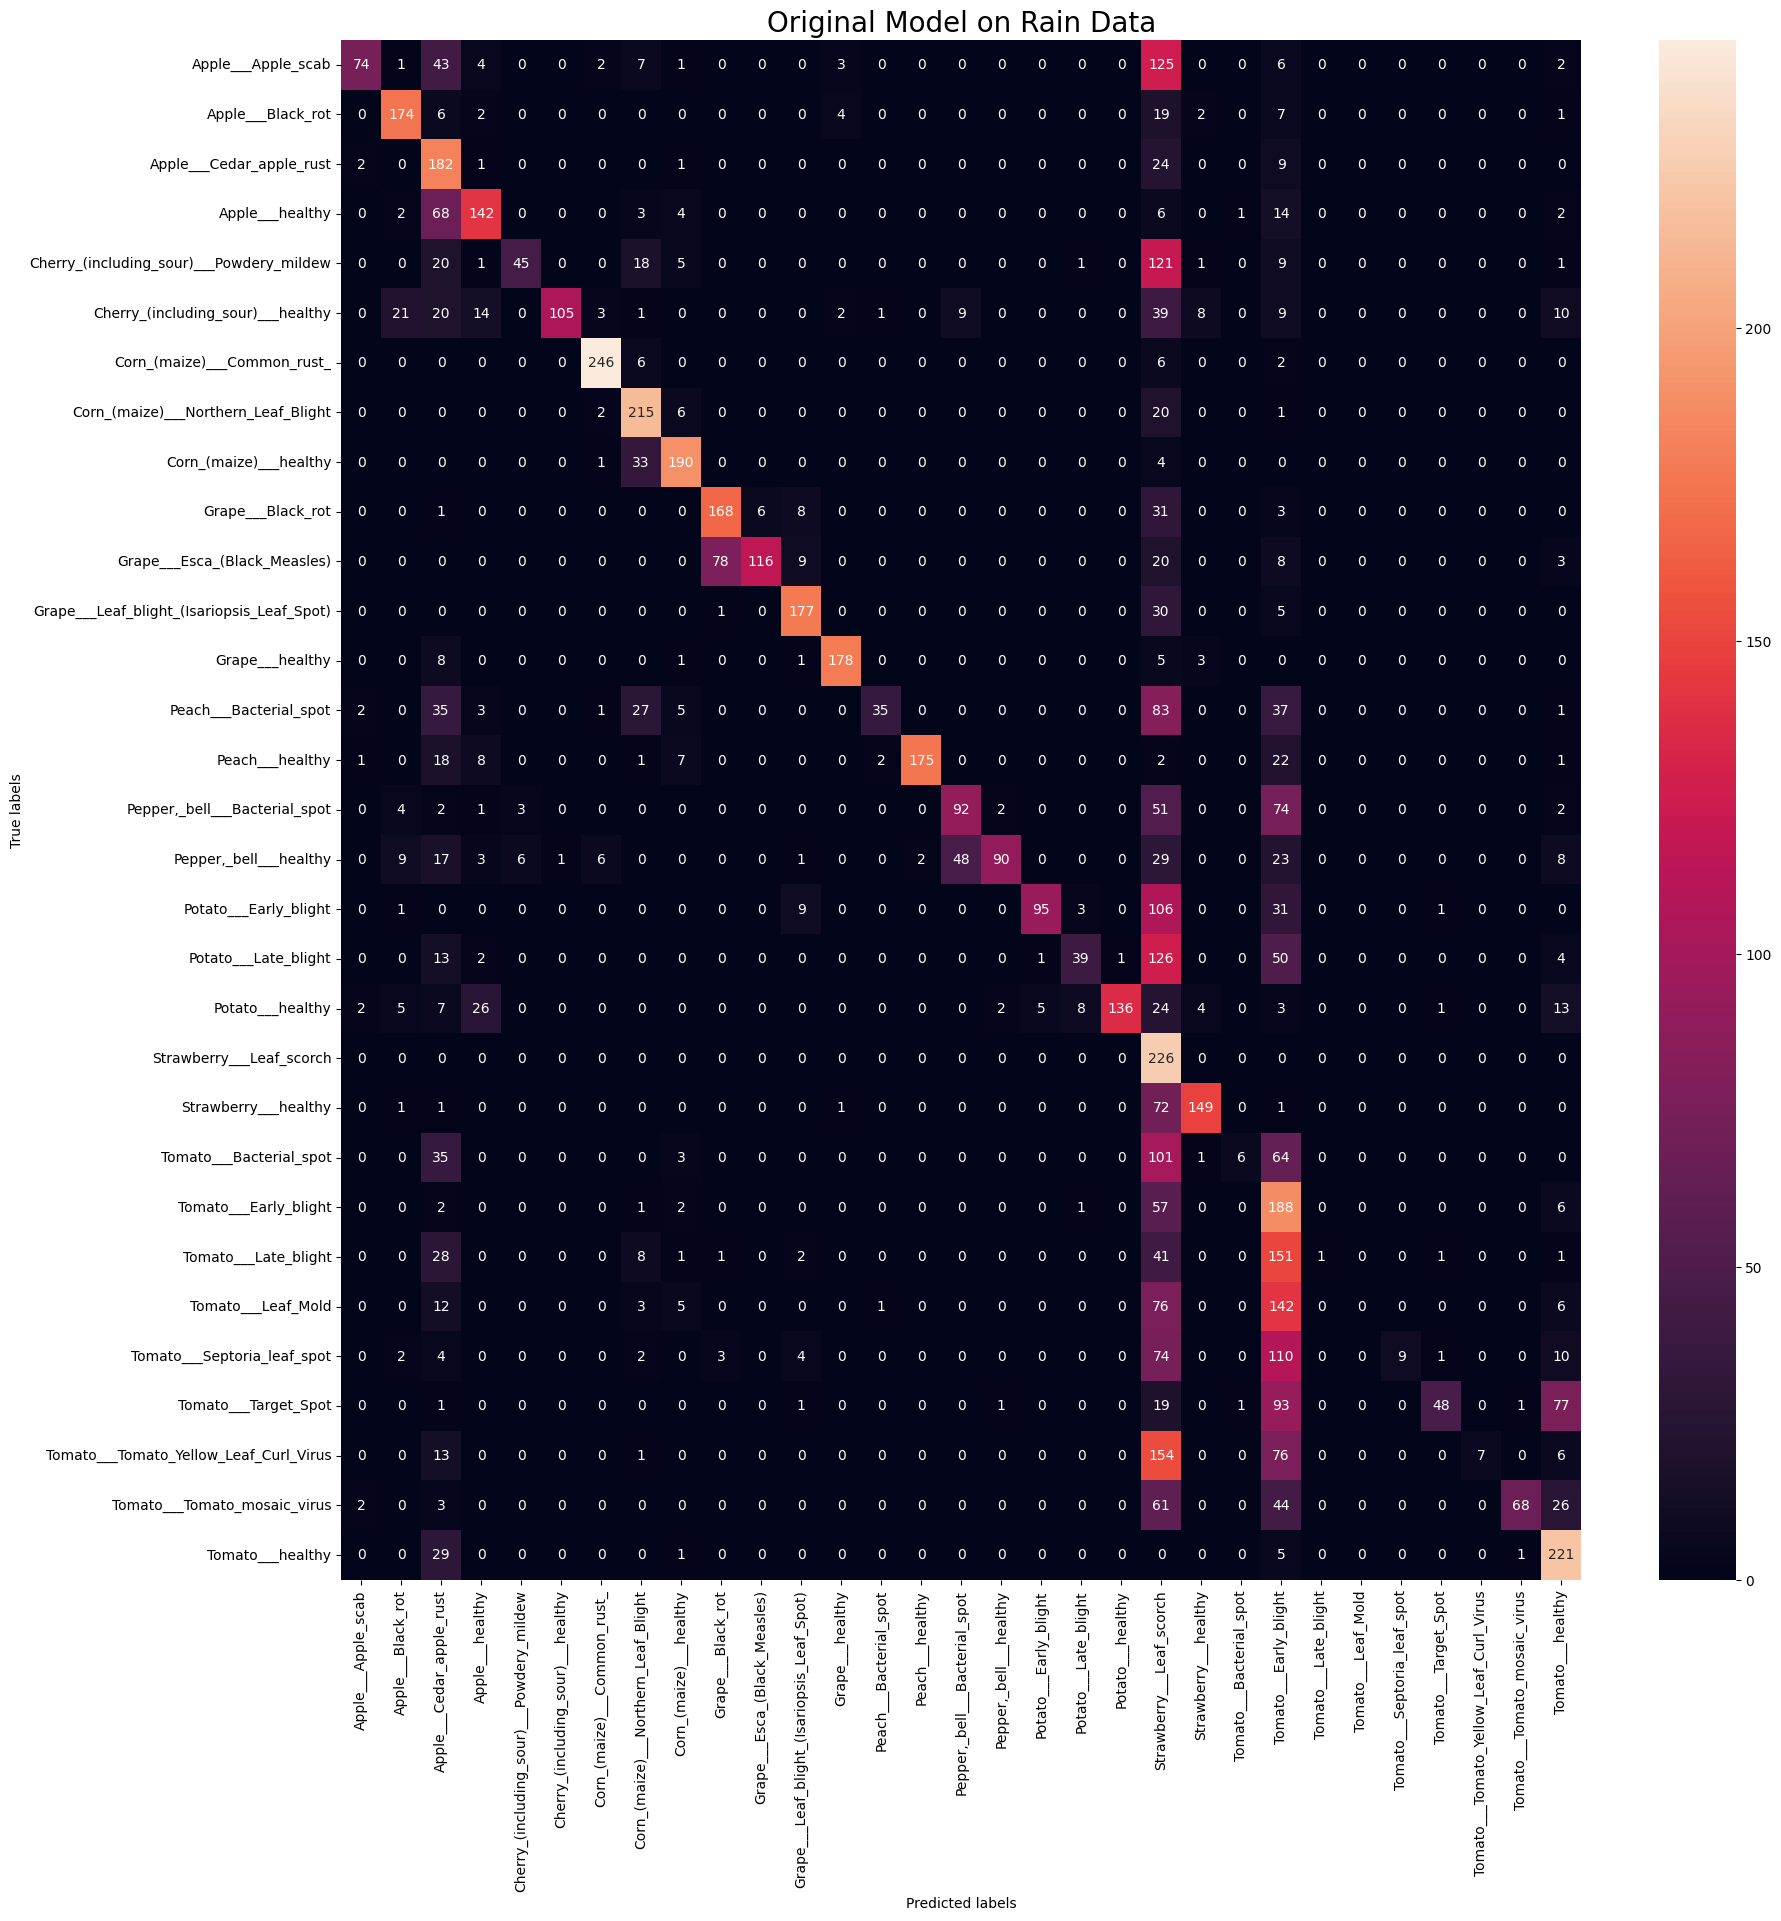

In [22]:
create_model_confusion_matrix(orig_model, rain_test_generator, 
                              "Original_Model_on_Rain_Data", rain_test_df, 
                              orig_rain_predictions)

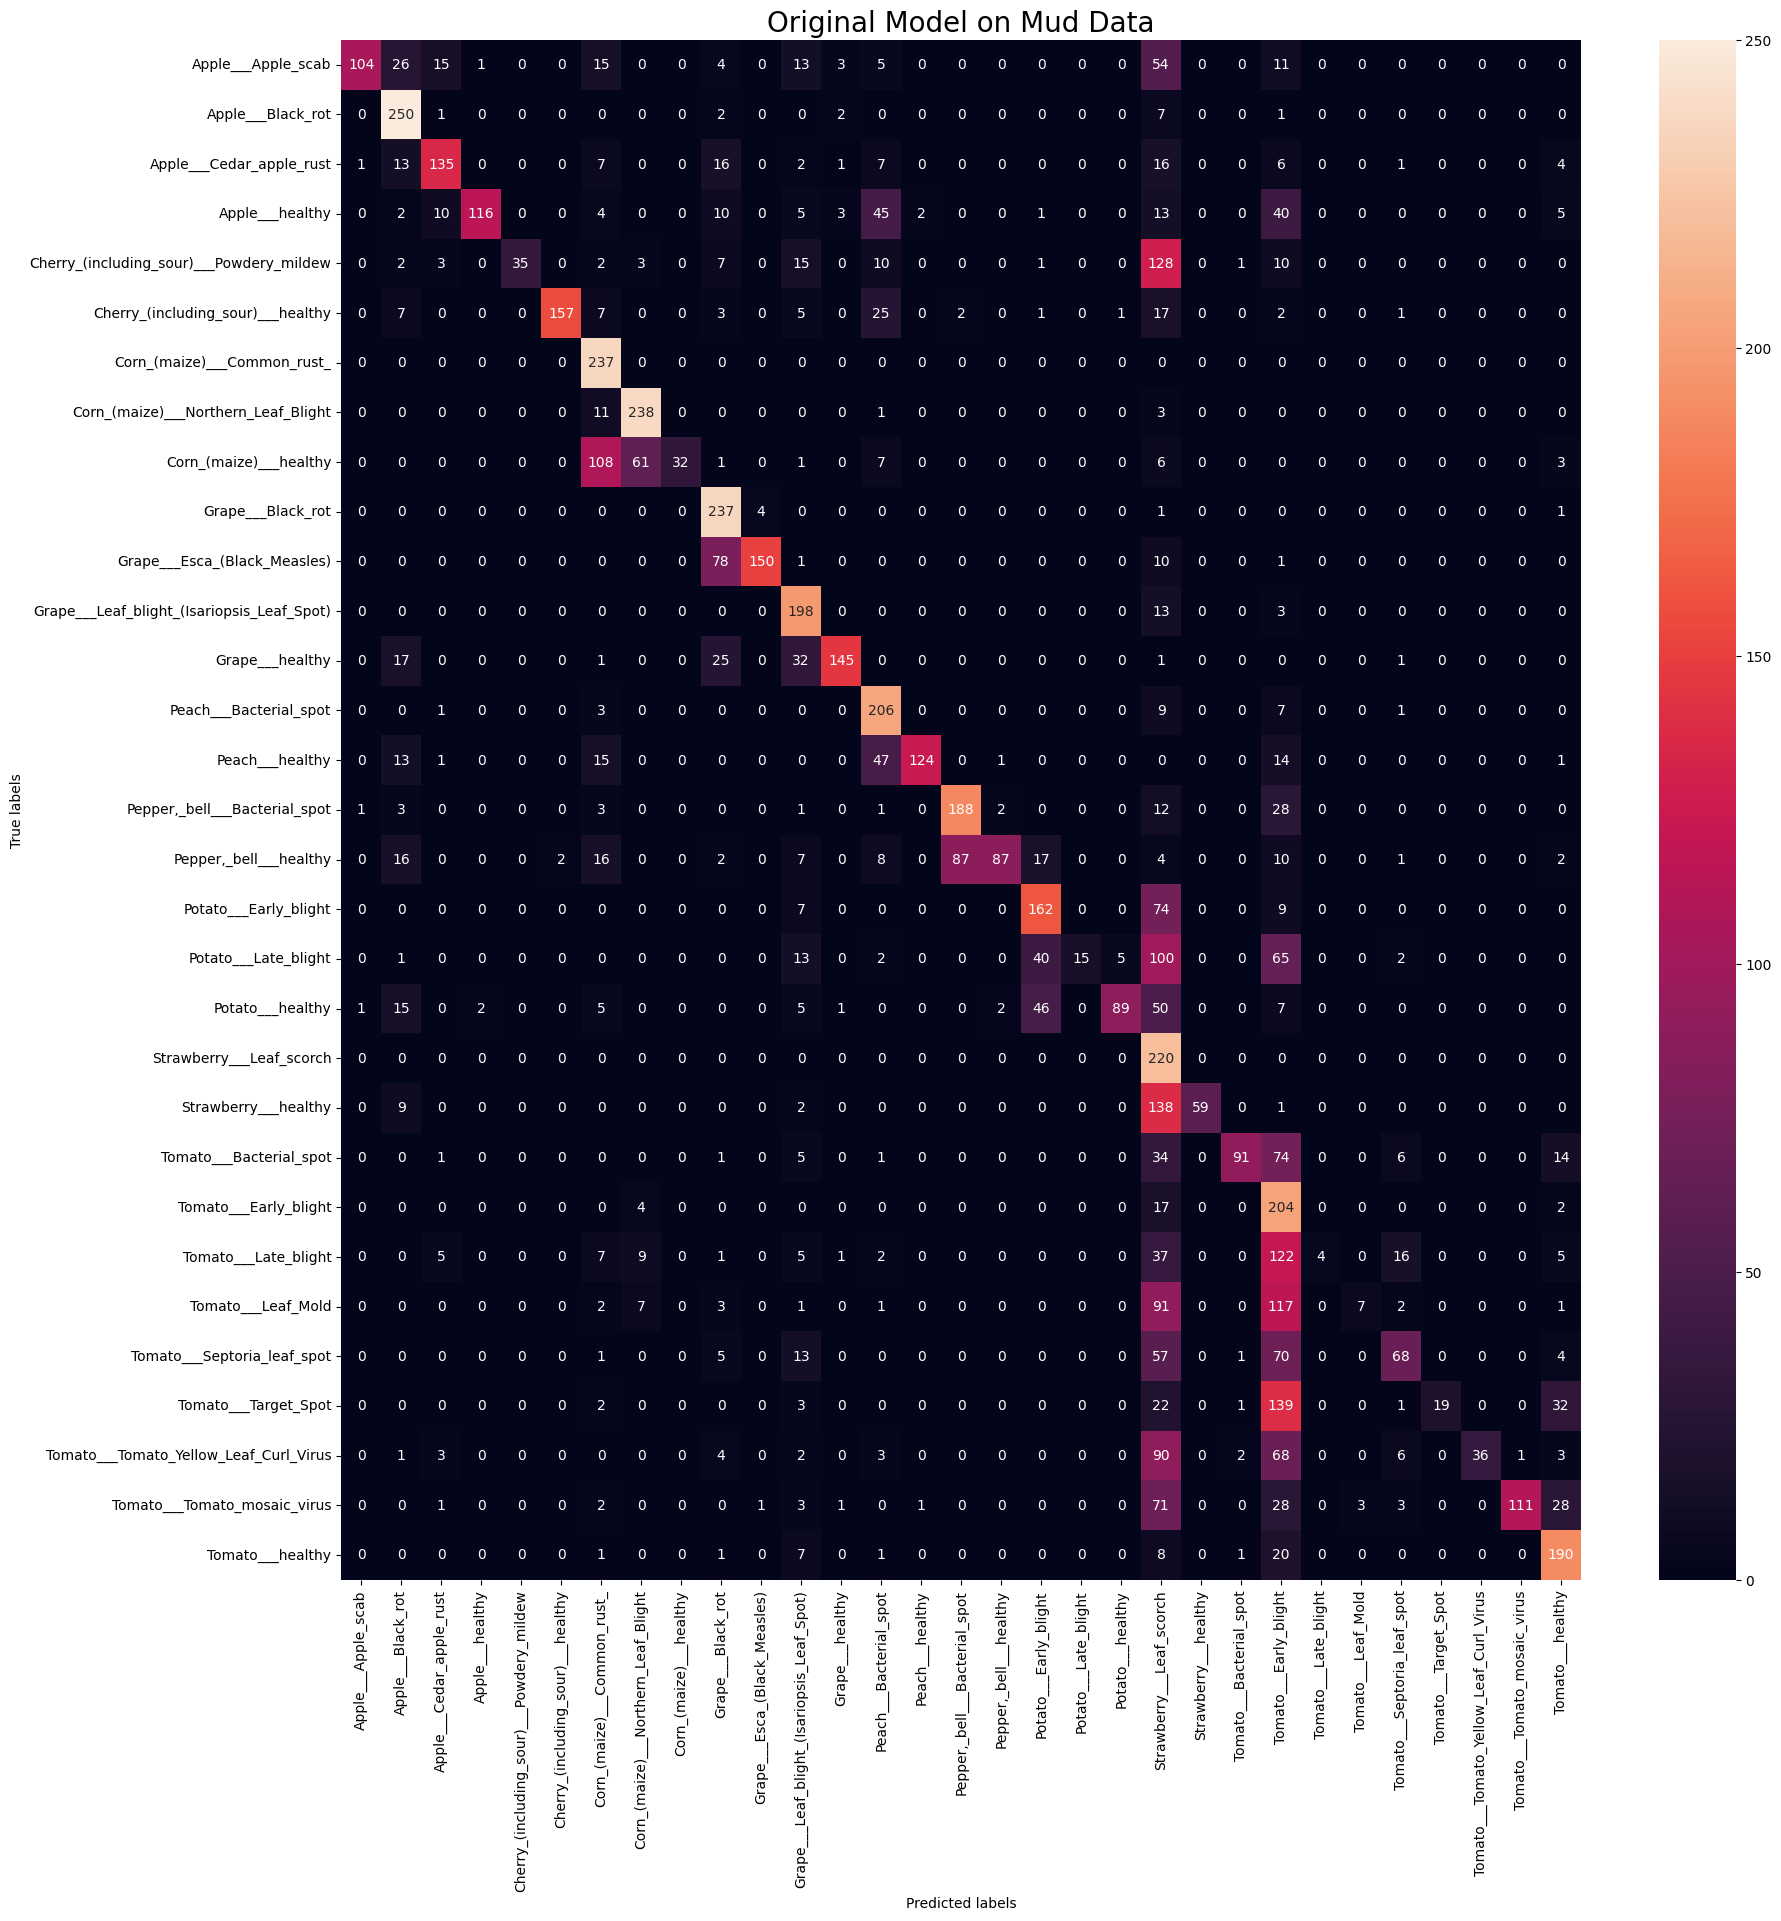

In [23]:
create_model_confusion_matrix(orig_model, mud_test_generator, 
                              "Original_Model_on_Mud_Data", mud_test_df, 
                              orig_mud_predictions)

# CM for Original Model

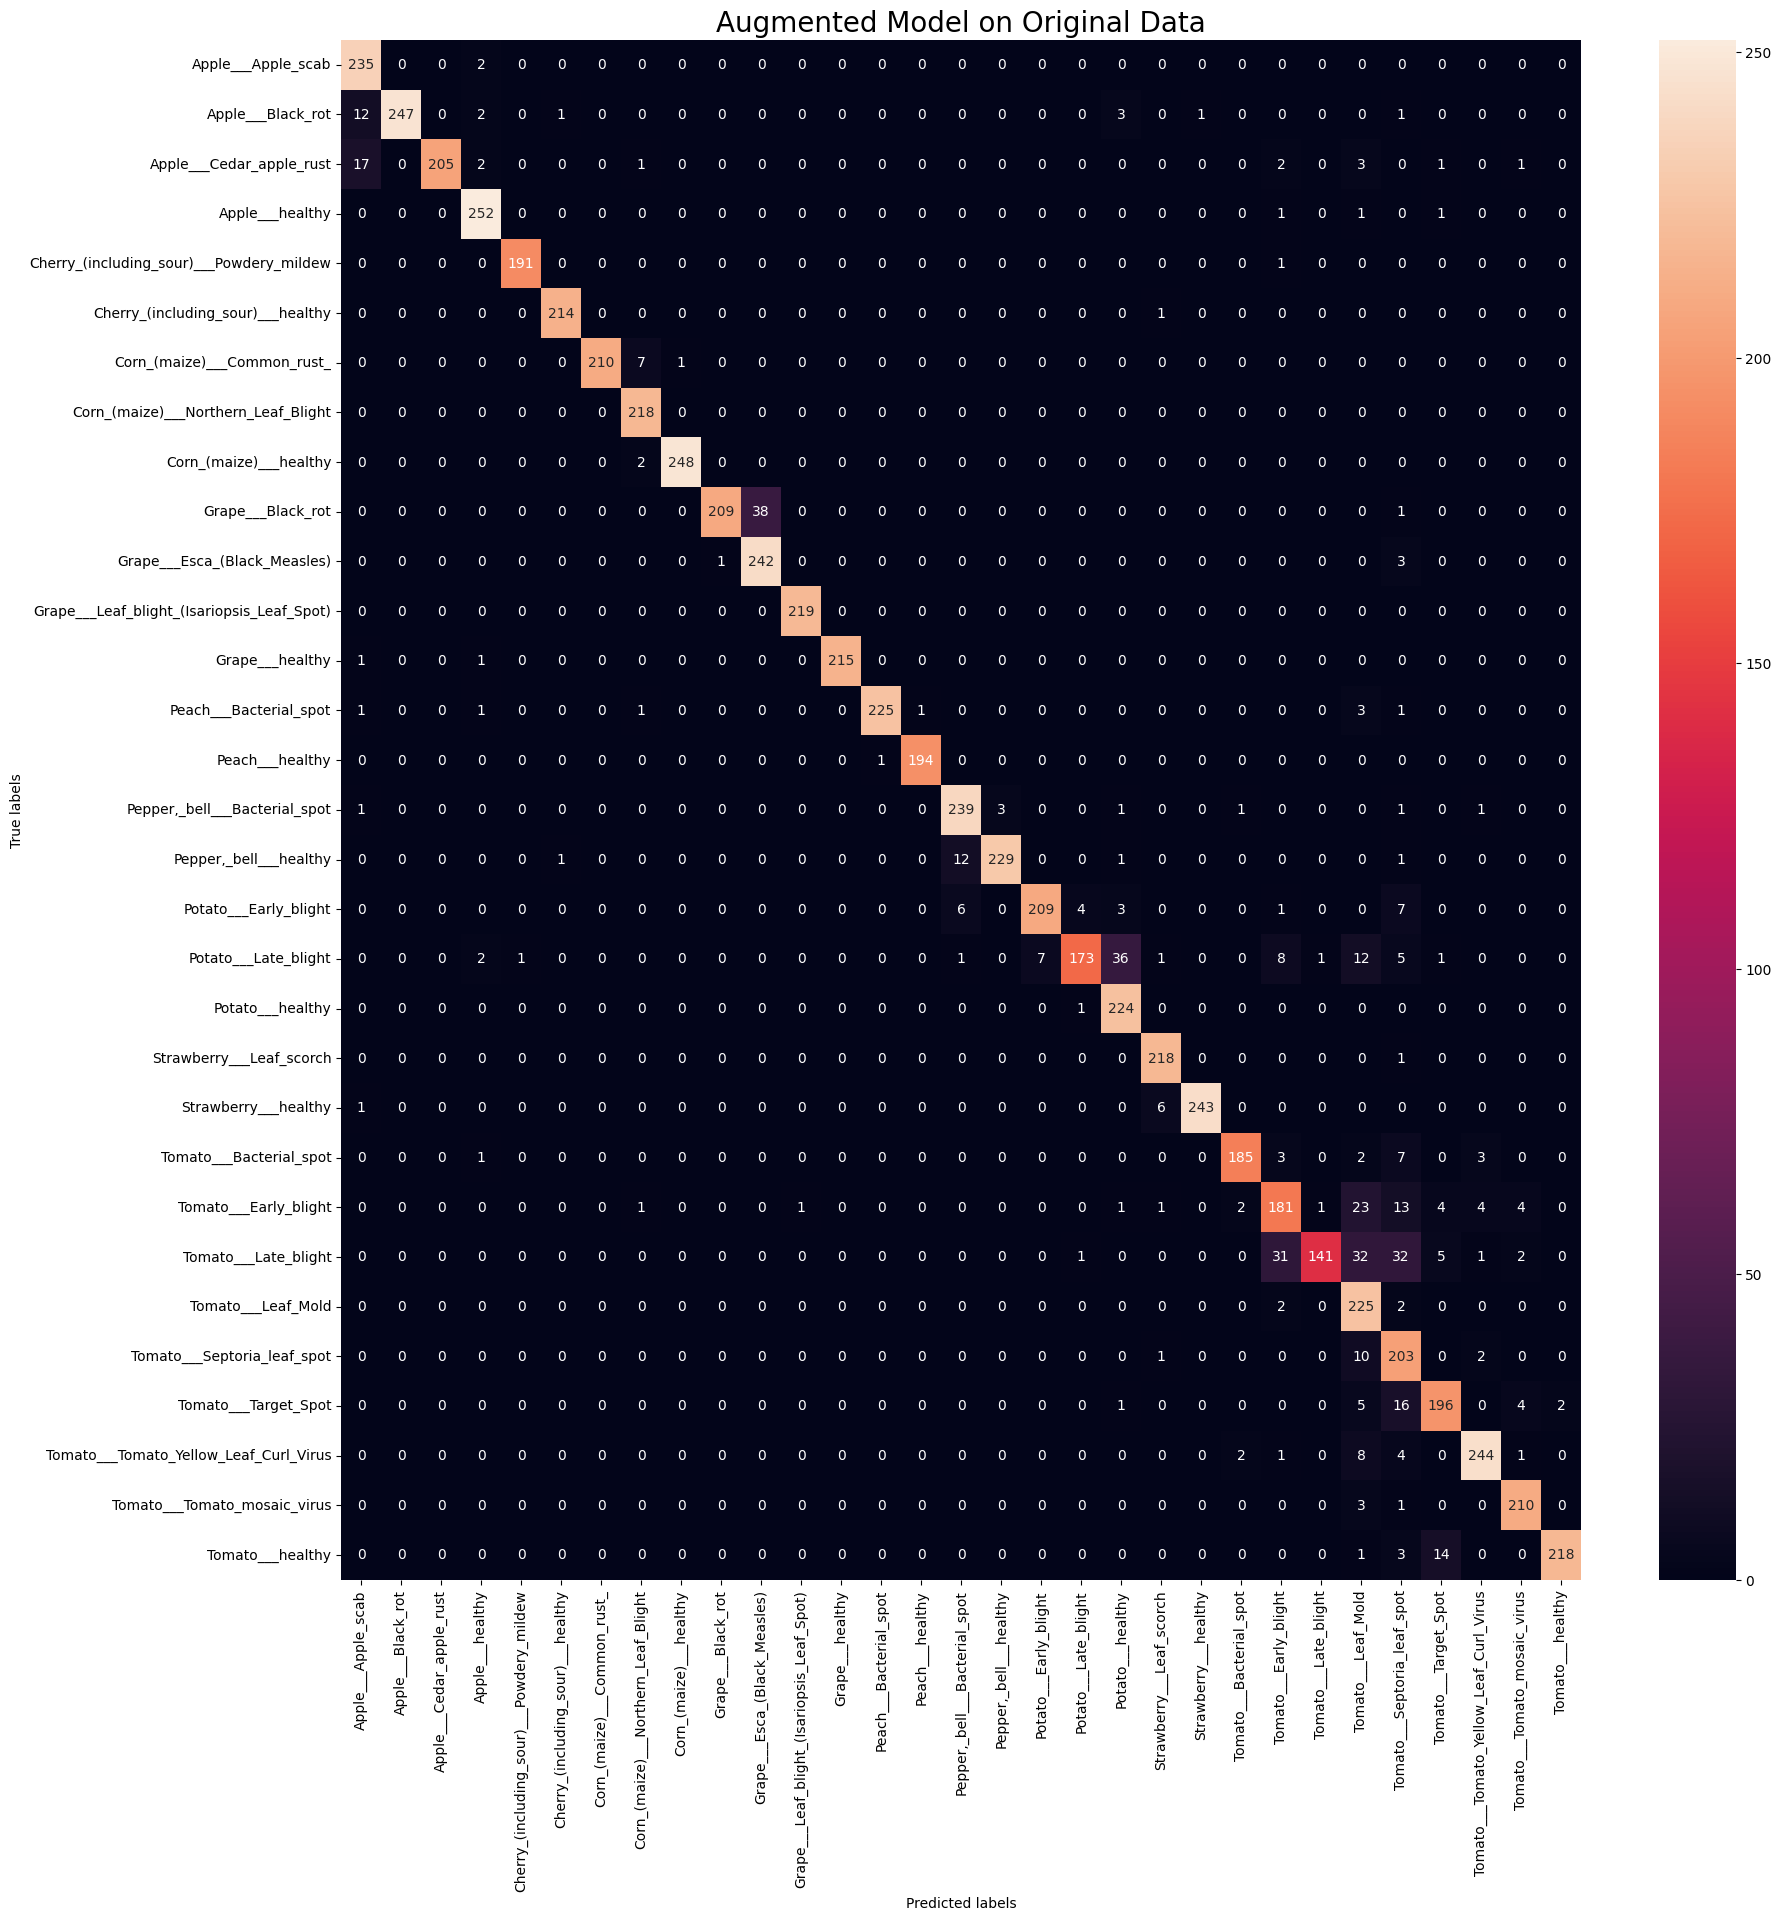

In [24]:
create_model_confusion_matrix(aug_model, orig_test_generator, 
                              "Augmented_Model_on_Original_Data", orig_test_df, 
                              aug_orig_predictions)

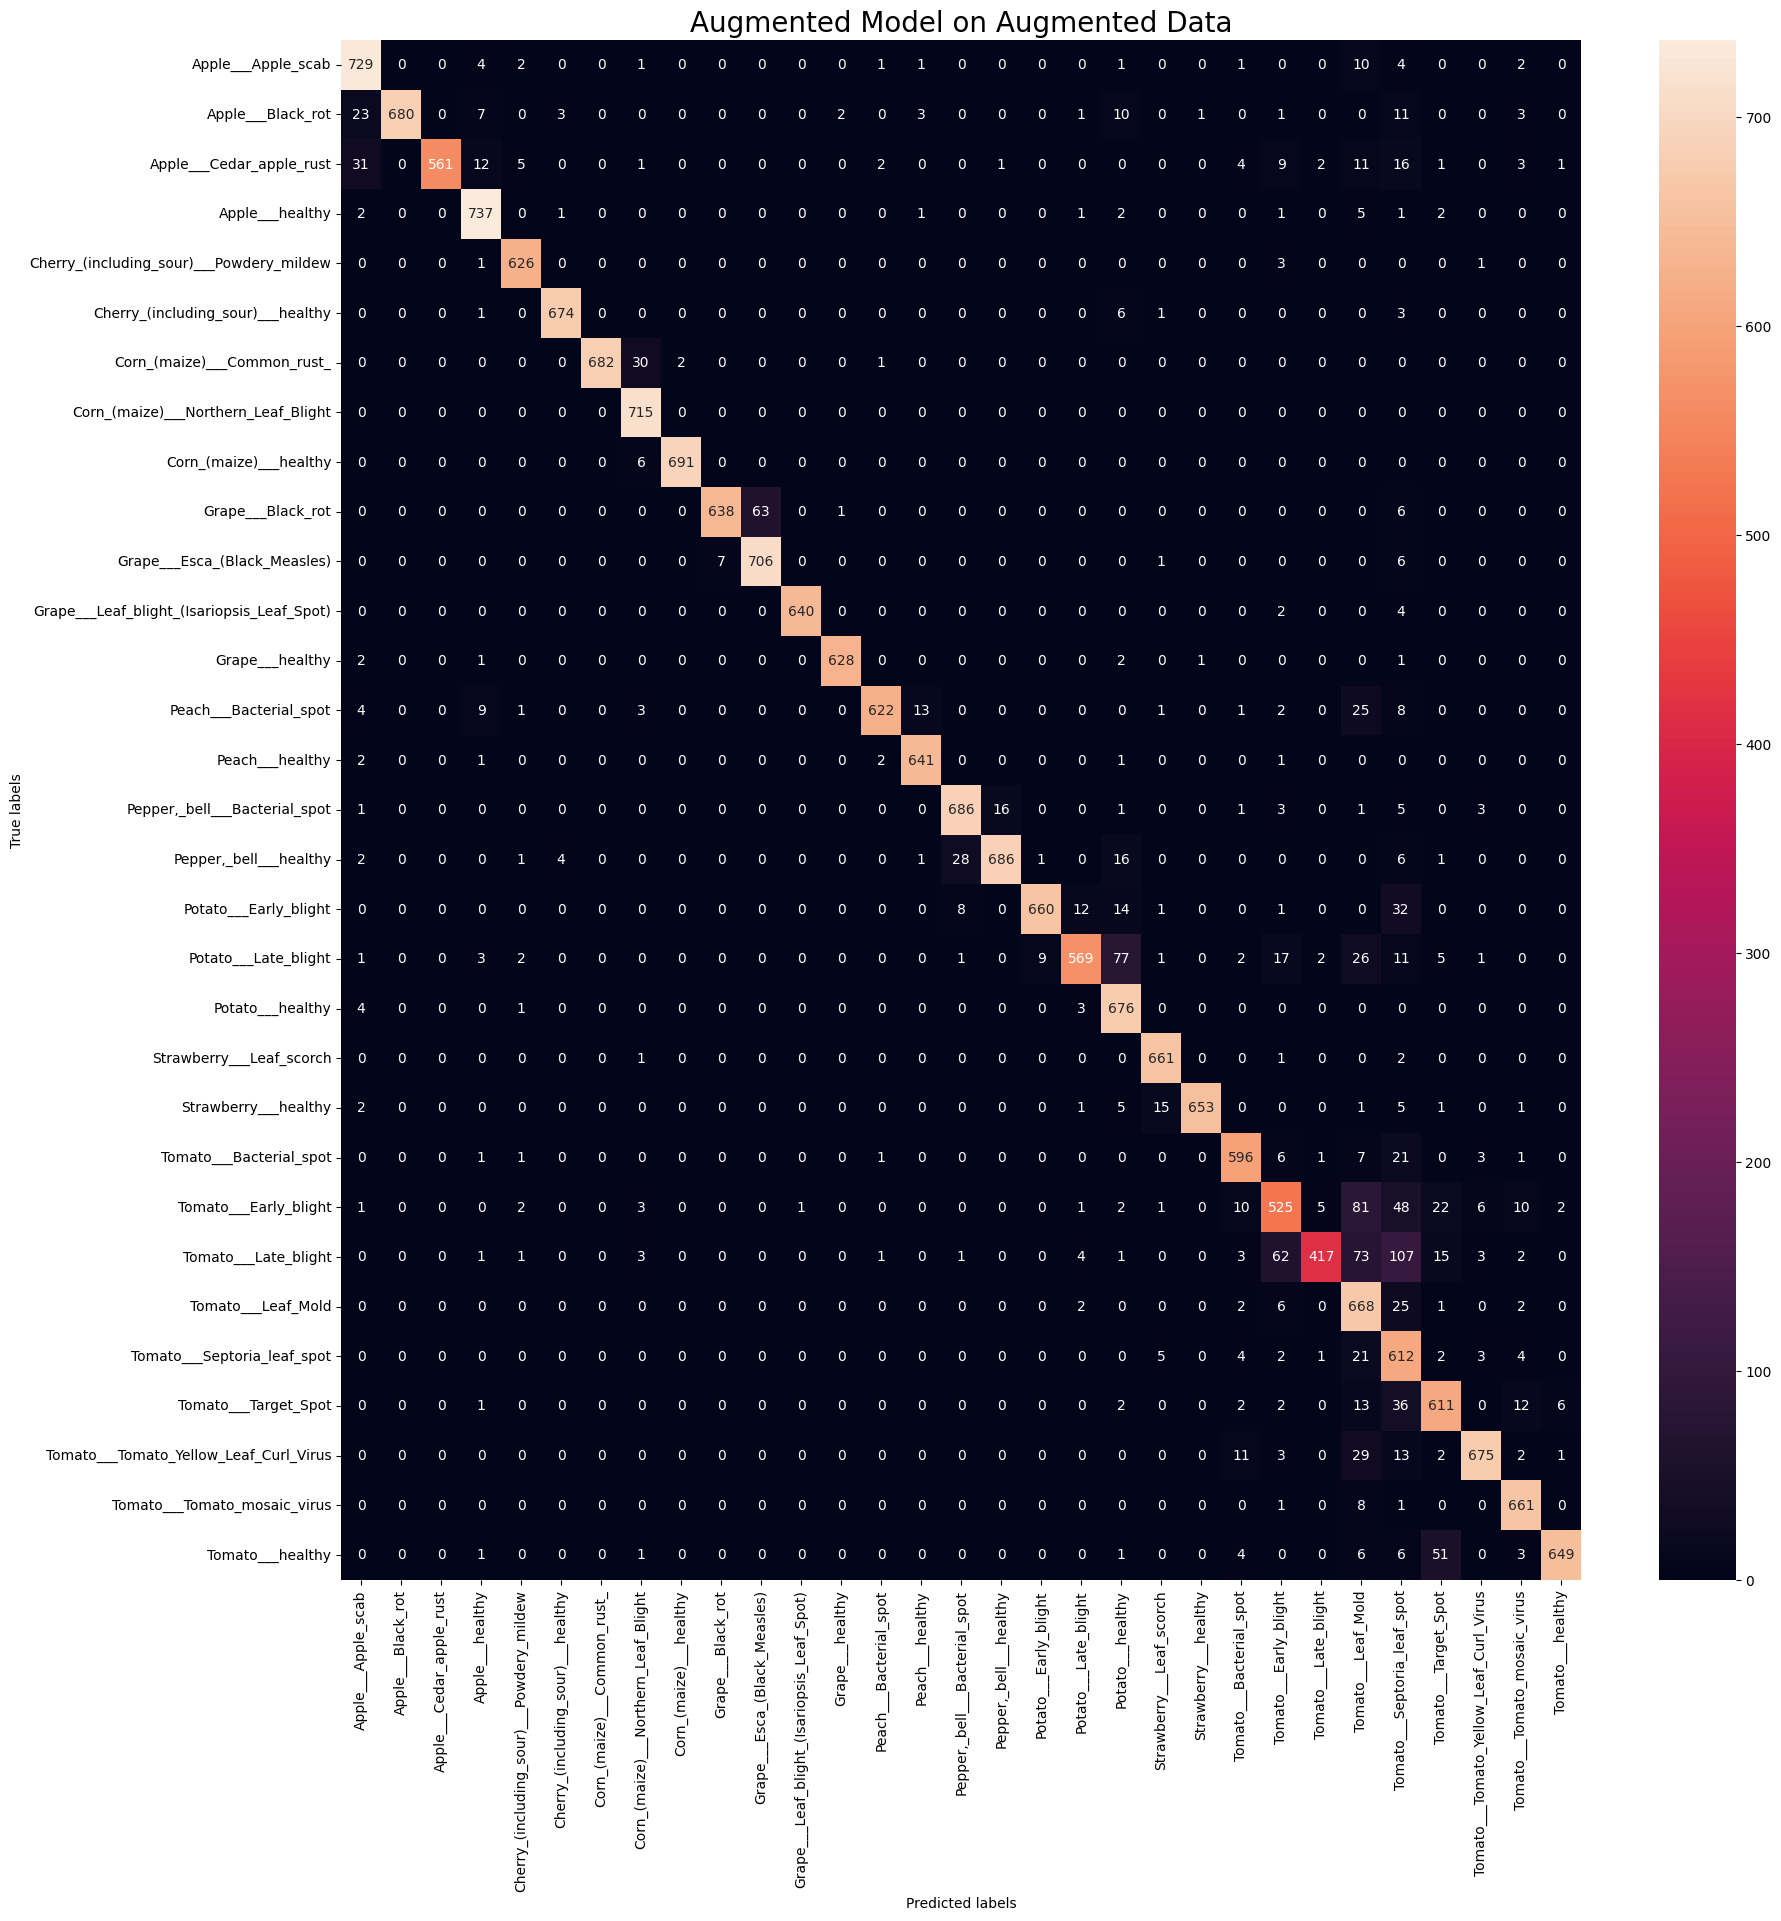

In [25]:
create_model_confusion_matrix(aug_model, aug_test_generator, 
                              "Augmented_Model_on_Augmented_Data", aug_test_df, 
                              aug_aug_predictions)

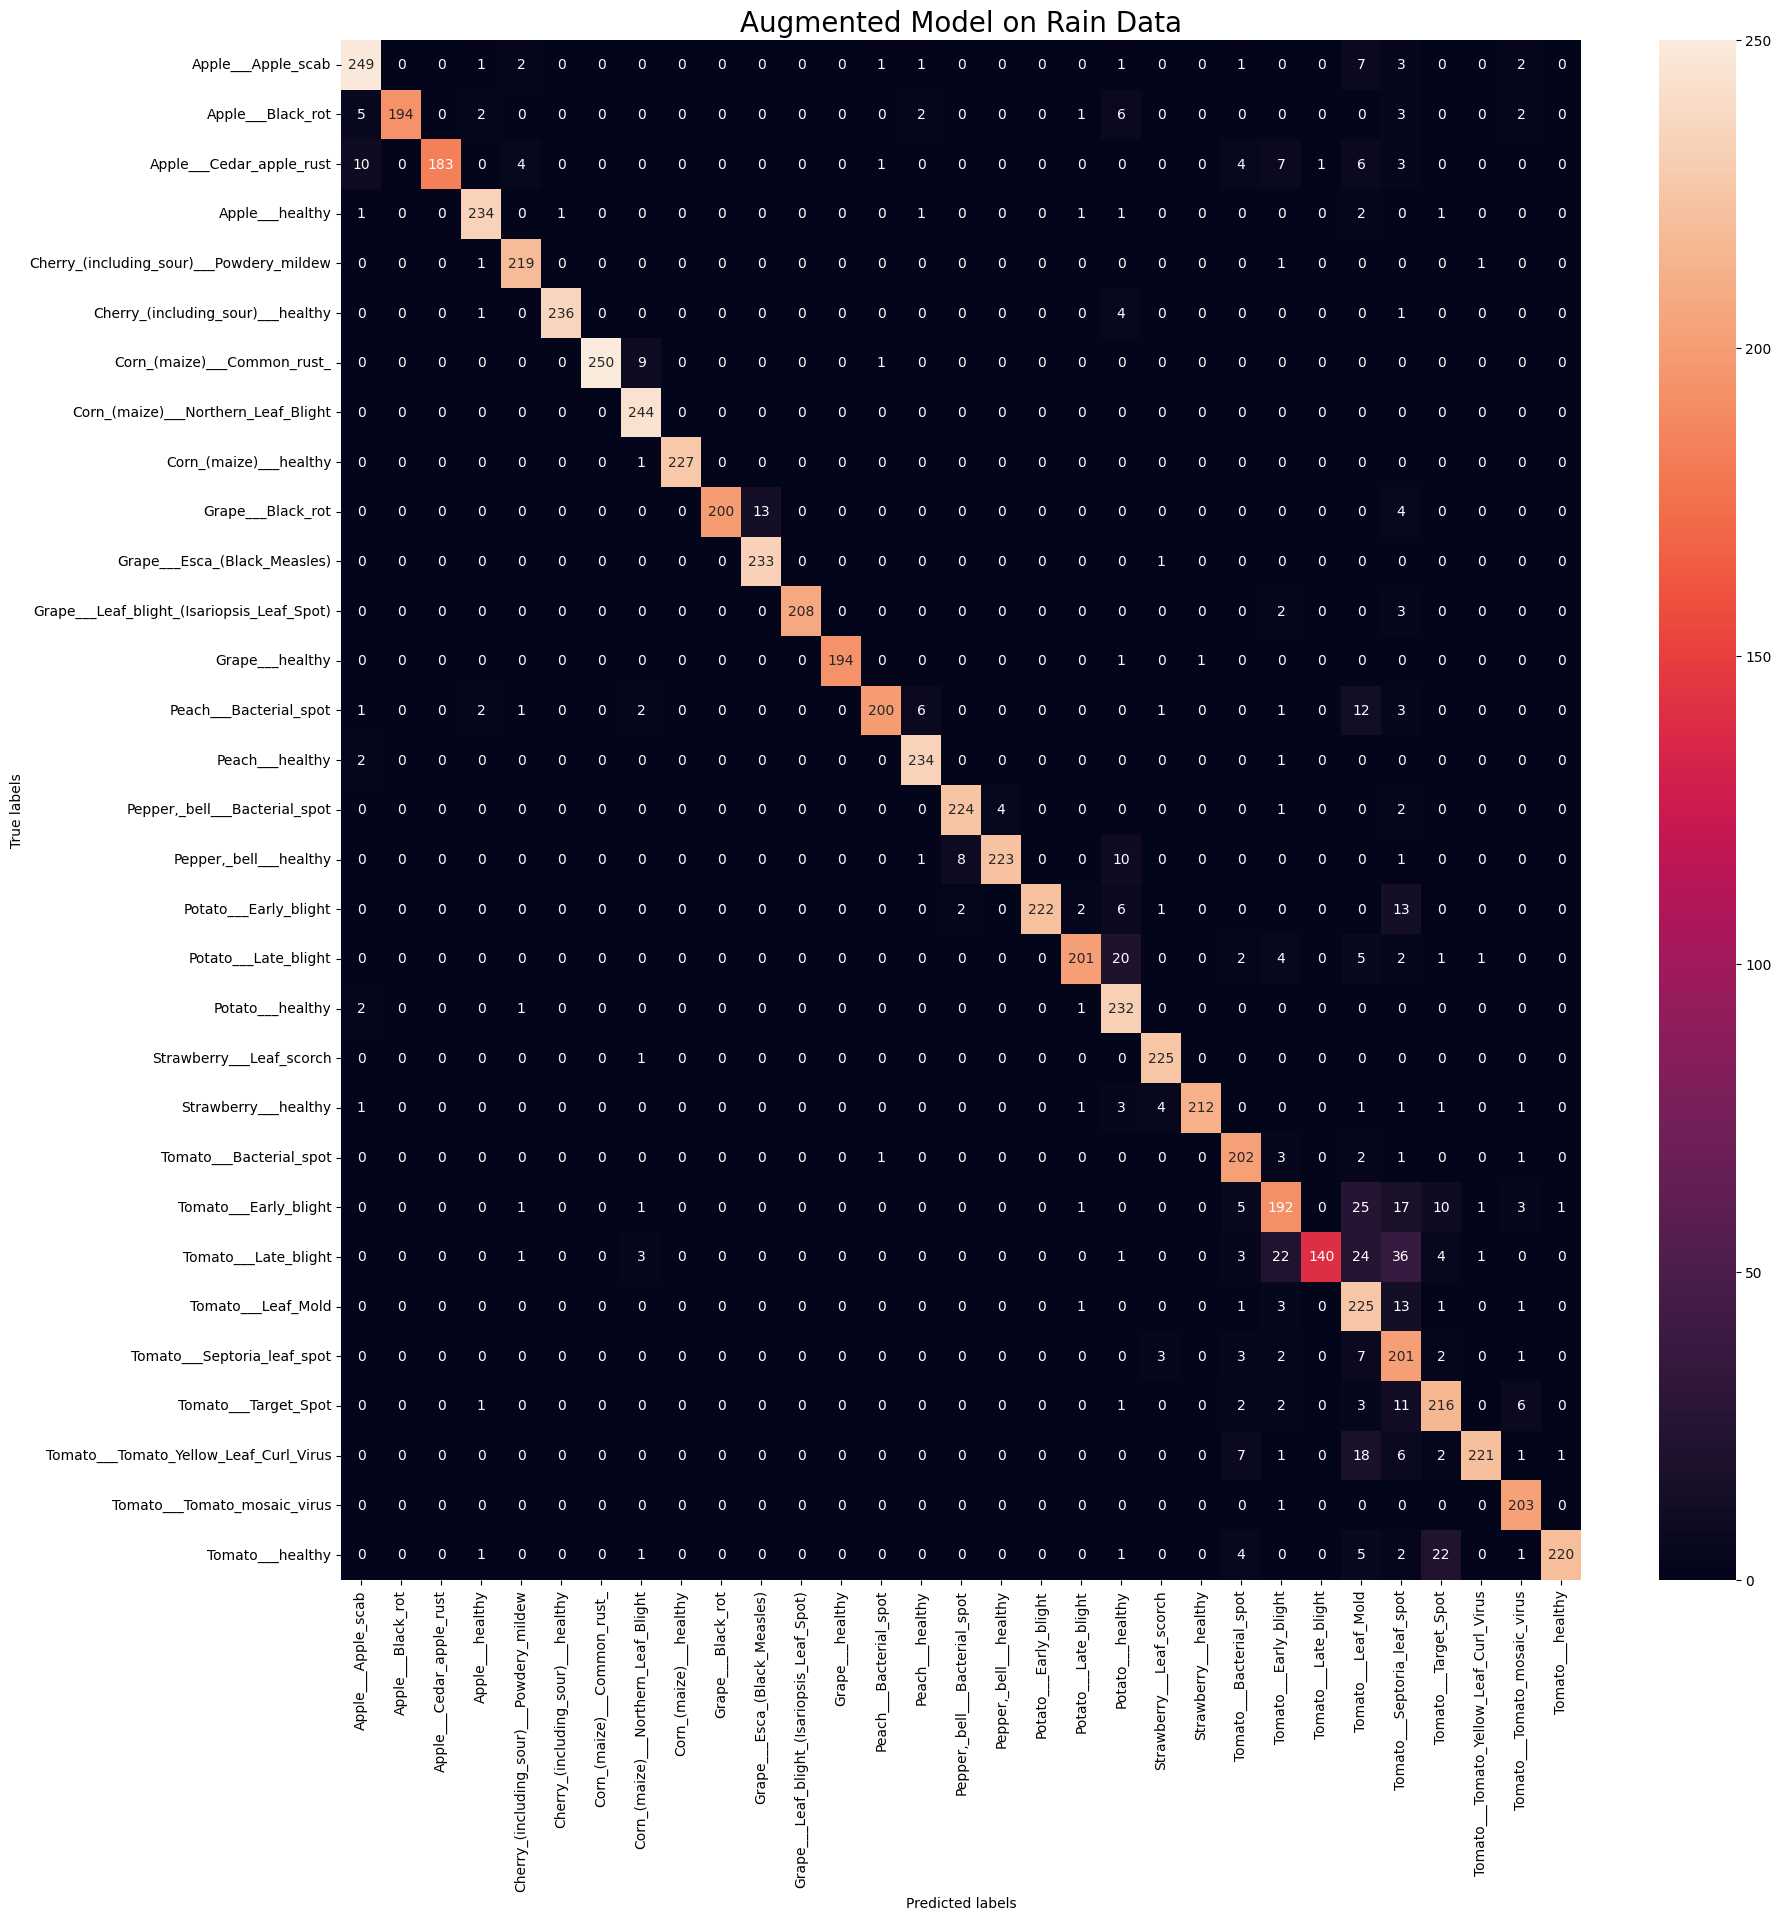

In [26]:
create_model_confusion_matrix(aug_model, rain_test_generator, 
                              "Augmented_Model_on_Rain_Data", rain_test_df, 
                              aug_rain_predictions)

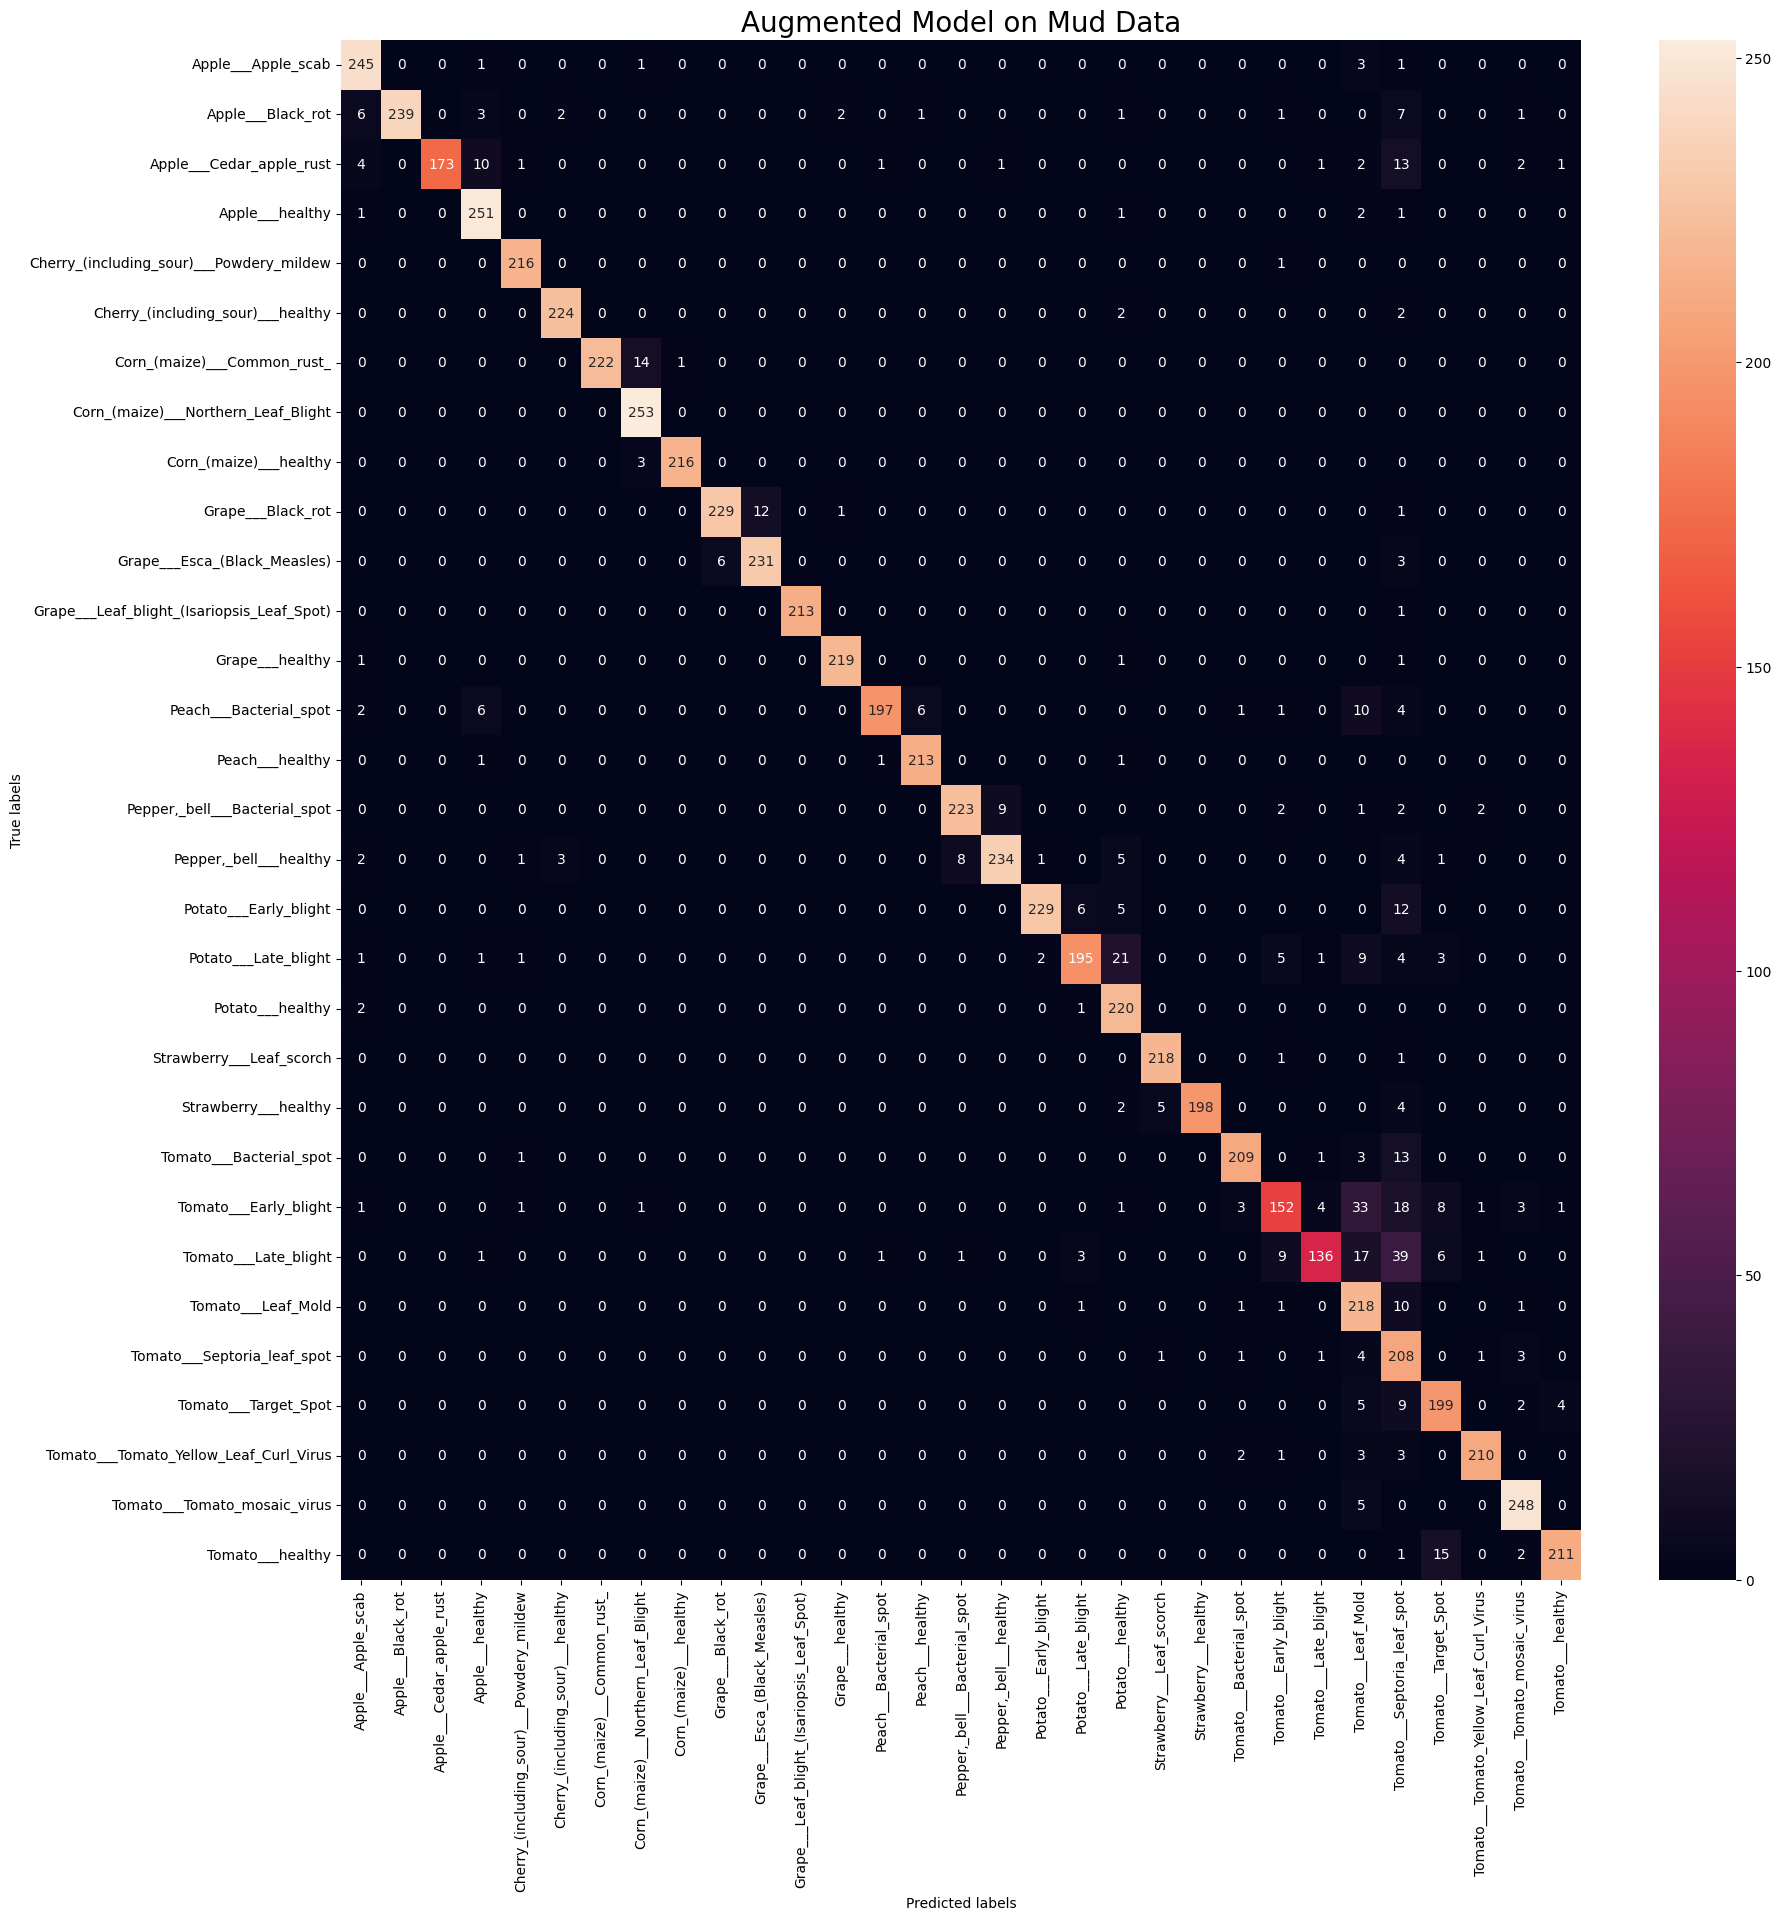

In [27]:
create_model_confusion_matrix(aug_model, mud_test_generator, 
                              "Augmented_Model_on_Mud_Data", mud_test_df, 
                              aug_mud_predictions)